In [34]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, feature
from skimage import filters, morphology
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# Load the TIFF image
image_path = '/Users/shreyasiperiketi/Desktop/sclcData/Adherent.tif'
image = cv2.imread(image_path)

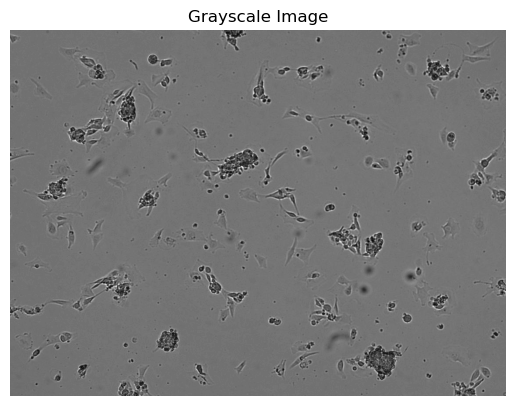

(832, 1128, 3) uint8


In [6]:
# Convert to grayscale if the image is in color
if len(image.shape) == 3:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

# Display the image
plt.imshow(image_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()
print(image.shape, image.dtype)

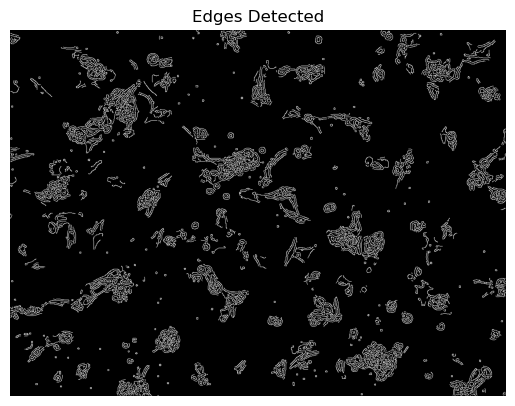

In [7]:
# Extract features using the Canny edge detector
edges = feature.canny(image_gray)

# Display the edges
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')
plt.show()

In [8]:
# Normalize the image data
image_normalized = image / 255.0

# Apply median filter to each slice for noise reduction
image_denoised = np.array([filters.median(slice, morphology.disk(3)) for slice in image_normalized])

In [11]:
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label

# Function to extract features from a single slice
def extract_features(slice_image):
    # Convert to binary image using Otsu's threshold
    thresh = threshold_otsu(slice_image)
    binary = slice_image > thresh

    # Label connected regions
    labeled_image = label(binary)
    
    # Extract region properties
    regions = regionprops(labeled_image, intensity_image=slice_image)

    # Initialize feature list
    features = []
    coordinates = []

    for region in regions:
        # Area
        area = region.area
        # Perimeter
        perimeter = region.perimeter
        # Eccentricity
        eccentricity = region.eccentricity
        # Mean intensity
        mean_intensity = region.mean_intensity
        # Centroid coordinates
        centroid = region.centroid

        # Append features and coordinates
        features.append([area, perimeter, eccentricity, mean_intensity])
        coordinates.append(centroid)

    return features, coordinates

# Extract features from a few slices
slice_indices = np.linspace(0, image.shape[0] - 1, 5, dtype=int)
all_features = []
all_coordinates = []

for idx in slice_indices:
    slice_features, slice_coordinates = extract_features(image_denoised[idx])
    all_features.extend(slice_features)
    all_coordinates.extend(slice_coordinates)

# Convert features to a Pandas DataFrame
features_df = pd.DataFrame(all_features, columns=['area', 'perimeter', 'eccentricity', 'mean_intensity'])

# Convert coordinates to a NumPy array
coordinates = np.array(all_coordinates)

# Display the shape of the feature array
print(features_df.shape)
print(features_df.head())

(26, 4)
     area  perimeter  eccentricity  mean_intensity
0  1461.0      976.0      0.999983        0.451592
1  1797.0     1200.0      0.999989        0.448335
2   552.0      370.0      0.999882        0.451257
3    12.0       10.0      0.683130        0.417647
4   183.0      124.0      0.998924        0.453166


In [12]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Feature selection using variance thresholding
selector = VarianceThreshold(threshold=0.01)
selected_features = selector.fit_transform(features_df)

In [39]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

In [28]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_features)

In [29]:
# Perform DBSCAN clustering on the principal components
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(principal_components)

# Add cluster labels to the dataframe
features_df['cluster'] = clusters

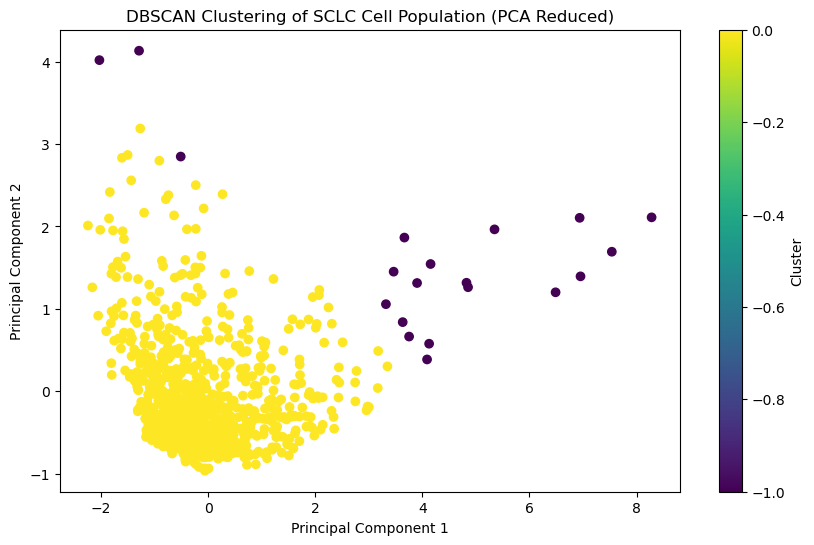

          0         1         2          3    4         5    6         7    8  \
0  0.442776  0.001496 -4.383300  21.124225  0.0  0.002364  0.0  0.171986  0.0   
1  0.443707  0.001277 -4.775378  26.053186  0.0  0.000591  0.0  0.163121  0.0   
2  0.443874  0.001230 -5.063114  30.526989  0.0  0.000591  0.0  0.155733  0.0   
3  0.441420  0.002036 -4.801182  26.113352  0.0  0.002364  0.0  0.145095  0.0   
4  0.439727  0.002962 -4.825459  27.707672  0.0  0.000591  0.0  0.153369  0.0   

          9   10        11        12        13  cluster  
0  0.477541  0.0  0.004728  0.188239  0.155142        0  
1  0.505024  0.0  0.001773  0.206856  0.122636        0  
2  0.488180  0.0  0.005615  0.195922  0.153960        0  
3  0.489362  0.0  0.002660  0.202719  0.157801        0  
4  0.477541  0.0  0.003251  0.192376  0.172872        0  


In [30]:
# Visualize the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering of SCLC Cell Population (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Display the features dataframe with cluster labels
print(features_df.head())

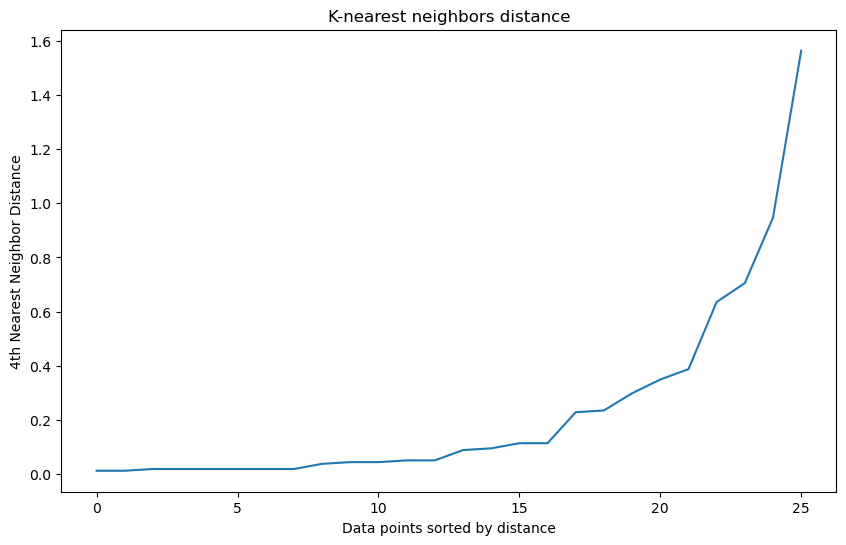

In [30]:
# Determine the best epsilon value using the k-nearest neighbors approach
k = 4
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = nearest_neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort the distances (4th column) in ascending order
distances = np.sort(distances[:, k-1])

# Plot the distances to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-nearest neighbors distance')
plt.xlabel('Data points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()